In [1]:
import pandas as pd
from pathlib import Path
import csv
import glob
import os
import matplotlib.pylab as plt
#for the various styles look at https://matplotlib.org/3.2.1/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-bright')
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix
%matplotlib inline


In [54]:
!ls
# you should see you are in the mainfolder where the netlogo .nlogo file is
# >>>>>>>>>>>>>>>>>  TO DO :  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
# Create a folder called 'data' where you put all the csv files
# create a folder called 'plots' for the plots
# >>>>>>>>>>>>>>>>>  TO DO end  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

 CodeSnippets.txt			        network-commons-main.py
 data					        network-commons.nlogo
'Experiments Parameters.md'		        networks
'Netlogo experiments csv file splitter.ipynb'   Networkx-commons.ipynb
 network-commons-analysis.ipynb		        README.md
 network-commons-analysis-playground.ipynb


In [3]:
# global parameters related to the structure of the file
# other global variables (like 'path')

col_names_index = ['[run number]','[step]' ]
col_names_parameters = ['nb-villagers', 'LINK-TRANSMISSION-DISTANCE','min-degree', 'adaptive-harvest?',
                       'network-type', 'MIN-RSC-SAVING-PCT', 'wiring-probability',
                       'regrowth-chooser', 'INIT-HARVEST-LEVEL','DECREASE-PCT', 'INCREASE-PCT',
                       'MAX-TURTLE-BACKPACK','HFC-TICKER-MAX','HFC-TICKER-STOP','HFC-TICKER-START',
                        'PRL-TICKER-MAX','PRL-TICKER-STOP','PRL-TICKER-START','FACTOR-DIV',
                        'PERCENT-BEST-LAND','regrowth-chooser','MAX-TURTLE-VISION', 'turtle-die?'
                       ]
col_names_reporters = ['total-resource-reporter','total-patch-regrowth','total-turtle-resource-reporter',
                       'total-quantity-harvested','number-of-hungry-turtles','total-wealth','total-food-exchanged']

col_names_reporters_group = ['group-turtle-resource','group-turtle-wealth','group-turtle-prl',
                             'group-turtle-hfc']
col_names_useless = ['show-link?','debugging-agentset?', 'debugging-agentset-nb','color-chooser',
                     'DEBUG-RATE','DEBUG','TURTLE-PROC-CHOOSER']
experiment_name=""

path = Path()   # sets path to the current directory

In [ ]:
#df.rename(columns={'total-resource-reporter':,'total-patch-regrowth','total-turtle-resource-reporter','total-quantity-harvested','number-of-hungry-turtles','total-wealth','total-food-exchanged'})

In [4]:
def process_netlogo_experiments_plots_per_run(df):
    for experiment in df.index.unique(level='experiment_name'):
        print("Processing experiment ", experiment)
        for run_number in df.index.unique(level='[run number]'):
            print("..processing run number ", run_number)
            sliced_df=df.xs( (experiment,run_number) )
            generate_reporters_vs_time(sliced_df, experiment, run_number)
            generate_total_resource_plot(sliced_df, experiment, run_number)
            generate_resource_exchanged_plot(sliced_df, experiment, run_number)
            generate_qty_harvested_vs_regrown_plot(sliced_df, experiment, run_number)
            generate_final_turtle_group_plots(sliced_df, experiment, run_number)

In [5]:
def generate_reporters_vs_time(sdf, experiment, run_number):
    for col_name in col_names_reporters:
        my_plot(sdf, col_name, experiment, run_number)


In [6]:
def my_plot(sdf, col_name: str, experiment: str, run_number: int):
    print('...Graph of {0} vs ticks'.format(col_name))
    title = "Experiment:{0}-Run#:{1}".format(experiment, run_number)
    sdf.plot(figsize=(15, 6), y = col_name, title=title)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_{2}_vs_ticks.png".format(experiment, run_number, col_name));

In [57]:
def read_netlogo_csv(csv_name: str, experiment_name_forced: str = "", run_prefix: str = ""):

    filename = path/'data'/csv_name
    
    if experiment_name_forced == "":

        # Find experiment name: read line 3 for experiment name (--> i== 2)

        with open(filename, "r") as f:
            reader = csv.reader(f, delimiter=",")
            for i, line in enumerate(reader):
                if i == 2:
                    experiment_name = line[0]
                    break
    else:
        experiment_name = experiment_name_forced
        #assert(run_prefix == "", 'please input a run number prefix if you force the experiment name')


    # read whole file into a pandas discarding useless columns

    df = pd.read_csv(filename, skiprows=6, sep=',',
                usecols=lambda x: x not in col_names_useless )
    
    
    # add a prefix to run number if the experiment name is "forced"
    
    if experiment_name_forced != "":
        df['[run number]'] = df['[run number]'].apply(lambda x: "{0}{1}".format(run_prefix, x))
        
    # insert the experiment name column and create the multiindex + sort


    df.insert(0, 'experiment_name', experiment_name)
    df.set_index(['experiment_name']+col_names_index, append=False, inplace=True)
    df.sort_index(inplace=True)

    df.head()  
    
    return df
    


In [48]:
def generate_total_resource_plot(sdf, experiment, run_number):
    # total resources is a plot vs time of the following reporters 
    #'total-resource-reporter','total-turtle-resource-reporter','total-quantity-harvested'
    col_names=['total-resource-reporter','total-turtle-resource-reporter','total-quantity-harvested']
    title = "Experiment:{0}-Run#:{1}".format(experiment, run_number)
    sdf[col_names].plot(figsize=(15, 6), title=title)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_Total_Resources_{2}_vs_ticks.png"
                 .format(experiment, run_number, col_names));

def generate_resource_exchanged_plot(sdf, experiment, run_number):
    col_names = ['total-food-exchanged']
    title = "Experiment:{0}-Run#:{1}".format(experiment, run_number)
    sdf[col_names].plot(figsize=(15, 6), title=title)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_QtyExchangedBetweenTurtles_Each_Tick.png"
                 .format(experiment, run_number, col_names));

def generate_qty_harvested_vs_regrown_plot(sdf, experiment, run_number):
    #'total-patch-regrowth','total-quantity-harvested' vs time
    col_names=['total-patch-regrowth','total-quantity-harvested']
    title = "Experiment:{0}-Run#:{1}".format(experiment, run_number)
    sdf[col_names].plot(figsize=(15, 6), style='.', title=title)
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_QtyHarvested_vs_QtyRegrown.png"
                 .format(experiment, run_number, col_names));
    
def generate_final_turtle_group_plots(sdf, experiment, run_number):
    pass

In [49]:
########### function ###############################################
#
#   FUNCTION TO LOAD ALL THE CSV FILES IN DATA  FOLDER INTO df
#
############################################################
# path = Path('/home/isischameleon/Dropbox/Coding/gitrepos/abm_commons_tragedy') 

def load_experiments_csv_files(csv_names: list = []):
    
    ''' Load multiple Netlogo experiments files into one dataframe df'''
    ''' e.g.csv_names = ['network-commons experiment #2.0 Network. min-degree 1-table.csv',
                         'network-commons experiment demo-table_decreasingfactordiv.csv']
    '''
    
    
    df_list = []
    
    if csv_names == []:
        os.chdir(path/'data')
        csv_names = glob.glob('*.{}'.format('csv'))
        os.chdir('..')
    
    print("Files about to be loaded into the dataframe : ", csv_names)
    
    for csv_name in csv_names:
        filename = path/'data'/csv_name
        df = read_netlogo_csv(csv_name)
        df_list.append(df)
        
    global_df = pd.concat(df_list, axis=0)
    
    return global_df
    
    


In [50]:
# ############# function ############################################################## 
#  MUTIPLE RUNS GRAPH GENERATORS - IE FOR THE SAME EXPERIMENT THESE FUNCTIONS WILL PUT
#  ALL RUNS ON THE SAME GRAPH
#  Functions to generate reports for multiple runs of the same experiment
##################################################################################

def generate_resource_exchanged_plot_for_multiple_run(sdf, experiment):
    col_names = ['total-food-exchanged']
    title = "Experiment:{0} all runs - {1} ".format(experiment, col_names)
    
    fig, ax = plt.subplots()
    ax.set_ylabel("{0}".format(col_names))
    
    run_number=""
    for index in sdf.index:
        if run_number != index[0]:
            # change of run in the same experiment
            run_number = index[0]
            ssdf=sdf.xs( (run_number) )
            
            ssdf.rename(columns=lambda x: "{0}-Run#{1}".format(x, run_number), inplace=True)
            new_col_names = []
            for col_name in col_names:
                new_col_name  = "{0}-Run#{1}".format(col_name, run_number)
                new_col_names.append(new_col_name)
            
            print("Generating {0} graph for run number {1}: ".format(col_names,run_number))
            ssdf[new_col_names].plot( figsize=(15, 6), title=title, ax=ax, label="Run{0}".format(run_number))
    
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_AllRuns_QtyExchangedBetweenTurtles_Each_Tick.png"
                 .format(experiment));

def generate_qty_harvested_vs_regrown_plot_for_multiple_run(sdf, experiment):
    #'total-patch-regrowth','total-quantity-harvested' vs time
    col_names=['total-patch-regrowth','total-quantity-harvested']
    title = "Experiment:{0} all runs - {1} ".format(experiment, col_names)
    
    fig, ax = plt.subplots()
    ax.set_ylabel("{0}".format(col_names))
    
    run_number=""
    for index in sdf.index:
        if run_number != index[0]:
            # change of run in the same experiment
            run_number = index[0]
            ssdf=sdf.xs( (run_number) )
            
            ssdf.rename(columns=lambda x: "{0}-Run#{1}".format(x, run_number), inplace=True)
            new_col_names = []
            for col_name in col_names:
                new_col_name  = "{0}-Run#{1}".format(col_name, run_number)
                new_col_names.append(new_col_name)
            
            print("Generating {0} graph for run number {1}: ".format(col_names,run_number))
            ssdf[new_col_names].plot( figsize=(15, 6), title=title, ax=ax, label="Run{0}".format(run_number))
    
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_AllRuns_QtyHarvested_vs_QtyRegrown.png"
                 .format(experiment));
    
    
def generate_final_turtle_group_plots_for_multiple_run(sdf, experiment):
    pass

def generate_total_resource_plot_for_multiple_run(sdf, experiment):
    # total resources is a plot vs time of the following reporters 
    #'total-resource-reporter','total-turtle-resource-reporter','total-quantity-harvested'
    col_names=['total-resource-reporter','total-turtle-resource-reporter','total-quantity-harvested']
    title = "Experiment:{0} all runs - {1} ".format(experiment, col_names)
    #print(sdf.index.name)
    #print(sdf.head())
    
    #df.reset_index(drop=False, inplace=True)
    #df.set_index(['[step]','[run number]', append=False, inplace=True)
    #ax = df1.plot()
    #df2.plot(ax=ax)
    
    fig, ax = plt.subplots()
    #ax.set_xlabel("ticks")
    ax.set_ylabel("quantity of resource")
    
    run_number=""
    for index in sdf.index:
        if run_number != index[0]:
            # change of run in the same experiment
            run_number = index[0]
            ssdf=sdf.xs( (run_number) )
            
            ssdf.rename(columns=lambda x: "{0}-Run#{1}".format(x, run_number), inplace=True)
            new_col_names = []
            for col_name in col_names:
                new_col_name  = "{0}-Run#{1}".format(col_name, run_number)
                new_col_names.append(new_col_name)
            
            print(" Column names for this run : ", new_col_names)
            #print(ssdf.head())
            print("Generating graph for run number : ", run_number)
            ssdf[new_col_names].plot( figsize=(15, 6), title=title, ax=ax, label="Run{0}".format(run_number))
                  
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_{1}_Total_Resources_{2}_vs_ticks.png".format(experiment, run_number, col_names));

In [51]:
############ PLOT PER EXPERIMENT (ALL RUNS IN SAME PLOT) #########################
#      CHOOSE YOUR OWN COLUMNS
# do it yourself function for plot generation per experiment
# all runs on the same plot
# choose the columns you want to plot
# see MAIN 4 for calling it

def generate_columns_vs_ticks_report_per_experiment(df, experiment: str, col_names: list):
    
    # SLICE DF FOR THAT EXPERIMENT
    
    sdf=df.xs( (experiment) )
    
    title = "Experiment:{0} all runs - {1} ".format(experiment, col_names)
    
    fig, ax = plt.subplots()
    ax.set_ylabel("{0}".format(col_names))
    
    run_number=""
    for index in sdf.index:
        if run_number != index[0]:
            # change of run in the same experiment
            run_number = index[0]
            ssdf=sdf.xs( (run_number) )
            
            ssdf.rename(columns=lambda x: "{0}-Run#{1}".format(x, run_number), inplace=True)
            new_col_names = []
            for col_name in col_names:
                new_col_name  = "{0}-Run#{1}".format(col_name, run_number)
                new_col_names.append(new_col_name)
            
            print("Generating {0} graph for run number {1}: ".format(col_names,run_number))
            ssdf[new_col_names].plot( figsize=(15, 6), title=title, ax=ax, label="Run{0}".format(run_number))
    
    fig1 = plt.gcf()
    plt.show()
    fig1.savefig(path/'data'/'plots'/"{0}_AllRuns_{1}.png"
                 .format(experiment, col_names));
    

In [52]:
# to parse the df file and create a separate graph for each experiment and each run (_per_run)
def process_netlogo_experiments_plots_per_experiment(df):
    
    df.sort_index(inplace=True)
    experiment=""
    run_number=""
    #for index, row in df.iterrows():
    for index in df.index:
        if experiment != index[0]:
            # reading a new changing experiment
            experiment = index[0]
            print("Processing experiment :", experiment)
            run_number = index[1]
            print("..Processing run number :", run_number)
            generate_all_reports_per_run(df, experiment, run_number)
            
        elif run_number != index[1]:
            # change of run in the same experiment
            run_number = index[1]
            sliced_df = df.xs( (experiment,run_number) )
            generate_all_reports_per_run(df, experiment, run_number)
            
    
# to put each run into a separate graph 
def generate_all_reports_per_run(df, experiment, run_number):
    sliced_df=df.xs( (experiment,run_number) )
    generate_reporters_vs_time(sliced_df, experiment, run_number)
    generate_total_resource_plot(sliced_df, experiment, run_number)
    generate_resource_exchanged_plot(sliced_df, experiment, run_number)
    generate_qty_harvested_vs_regrown_plot(sliced_df, experiment, run_number)
    generate_final_turtle_group_plots(sliced_df, experiment, run_number) 

    
# to put all the runs into one graph per experiment
def generate_all_reports_per_experiment(df, experiment):
    sliced_df=df.xs( (experiment) )
    #1 - generate the total resource plot for multiple runs and the same experiment
    generate_total_resource_plot_for_multiple_run(sliced_df, experiment)
    generate_resource_exchanged_plot_for_multiple_run(sliced_df, experiment)
    generate_qty_harvested_vs_regrown_plot_for_multiple_run(sliced_df, experiment)
    

         

In [ ]:
# generate histogram

def generate_histogram_per_run(df, col_names):
    pass


In [59]:
########### MAIN 1 (1) - Data input ###############################################
#
#   READ 1 CSV FILES INTO THE DATAFRAME df
#   !!!! CHOOSE MAIN 1 (1) OR MAIN 1 (2) TO LOAD df
#
############################################################

# Input:
#--------

#csv_name = 'network-commons experiment#1.3  500 turtles BACKPACK 3-table.csv'  
csv_name = 'network-commons experiment demo-table_decreasingfactordiv.csv'


# processing:
# -----------
df = read_netlogo_csv(csv_name)

df.head()



DECREASE-PCT  min-degree  \
experiment_name [run number] [step]                             
experiment demo 1            0                0.1           2   
                             1                0.1           2   
                             2                0.1           2   
                             3                0.1           2   
                             4                0.1           2   

                                     adaptive-harvest?  MAX-TURTLE-BACKPACK  \
experiment_name [run number] [step]                                           
experiment demo 1            0                    True                    4   
                             1                    True                    4   
                             2                    True                    4   
                             3                    True                    4   
                             4                    True                    4   

                                     INIT-HARVEST-LEVEL  INCREASE-PCT  \
experiment_name [run number] [step]                                     
experiment demo 1            0                        1           0.1   
                             1                        1           0.1   
                             2                        1           0.1   
                             3                        1           0.1   
                             4                        1           0.1   

                                     HFC-TICKER-MAX  nb-villagers  \
experiment_name [run number] [step]                                 
experiment demo 1            0                   10           250   
                             1                   10           250   
                             2                   10           250   
                             3                   10           250   
                             4                   10           250   

                                     LINK-TRANSMISSION-DISTANCE  \
experiment_name [run number] [step]                               
experiment demo 1            0                                1   
                             1                                1   
                             2                                1   
                             3                                1   
                             4                                1   

                                     PRL-TICKER-MAX  ... total-patch-regrowth  \
experiment_name [run number] [step]                  ...                        
experiment demo 1            0                   10  ...                 0.00   
                             1                   10  ...               405.30   
                             2                   10  ...               603.70   
                             3                   10  ...               692.90   
                             4                   10  ...               706.38   

                                     total-turtle-resource-reporter  \
experiment_name [run number] [step]                                   
experiment demo 1            0                             0.000000   
                             1                           409.622000   
                             2                           854.482875   
                             3                          1292.934200   
                             4                          1718.129051   

                                     total-quantity-harvested  \
experiment_name [run number] [step]                             
experiment demo 1            0                       0.000000   
                             1                     902.772000   
                             2                     944.860875   
                             3                     938.451325   
                             4                     925.194851   

                                     nu

In [62]:
########### MAIN 1 (2) - Data input ###############################################
#
#   READ A LIST OF CSV FILES INTO THE DATAFRAME df
#   
#   yOU CAN FORCE EXPERIMENT NAME TO BE THE SAME FOR ALL OF THOSE CSV FILES
#   INSTEAD OF TAKING THE EXPERIMENT NAME IN THE CSV FILES 
#   !! The run numbers will be changed otherwise for example the run number one 
#   in 2 different files will be mixed.
#   
#
############################################################

#input
#-----

csv_names = ['network-commons experiment demo-table_decreasingfactordiv.csv',
            'network-commons experiment #2.0 Network. min-degree 1-table.csv']
experiment_name_forced = 'new name for my experiment'

#processing
#----------

df_list = []
i=0
for csv_name in csv_names:
    df = read_netlogo_csv(csv_name, experiment_name_forced, '{0}.'.format(i))
    i = i+1
    df_list.append(df)
    
df = pd.concat(df_list, axis=0)

df.head()
    


DECREASE-PCT  min-degree  \
experiment_name            [run number] [step]                             
new name for my experiment 0.1          0                0.1           2   
                                        1                0.1           2   
                                        2                0.1           2   
                                        3                0.1           2   
                                        4                0.1           2   

                                                adaptive-harvest?  \
experiment_name            [run number] [step]                      
new name for my experiment 0.1          0                    True   
                                        1                    True   
                                        2                    True   
                                        3                    True   
                                        4                    True   

                                                MAX-TURTLE-BACKPACK  \
experiment_name            [run number] [step]                        
new name for my experiment 0.1          0                         4   
                                        1                         4   
                                        2                         4   
                                        3                         4   
                                        4                         4   

                                                INIT-HARVEST-LEVEL  \
experiment_name            [run number] [step]                       
new name for my experiment 0.1          0                        1   
                                        1                        1   
                                        2                        1   
                                        3                        1   
                                        4                        1   

                                                INCREASE-PCT  HFC-TICKER-MAX  \
experiment_name            [run number] [step]                                 
new name for my experiment 0.1          0                0.1              10   
                                        1                0.1              10   
                                        2                0.1              10   
                                        3                0.1              10   
                                        4                0.1              10   

                                                nb-villagers  \
experiment_name            [run number] [step]                 
new name for my experiment 0.1          0                250   
                                        1                250   
                                        2                250   
                                        3                250   
                                        4                250   

                                                LINK-TRANSMISSION-DISTANCE  \
experiment_name            [run number] [step]                               
new name for my experiment 0.1          0                                1   
                                        1                                1   
                                        2                                1   
                                        3                                1   
                                        4                                1   

                                                PRL-TICKER-MAX  ...  \
experiment_name            [run number] [step]                  ...   
new name for my experiment 0.1          0                   10  ...   
                                        1                   10  ...   
                                        2                   10  ...   
                                        3                   10  ...   
                                        4                  

In [2]:
#############  MAIN 1 (3) - Data input  ##################
#  
#   LOAD ALL CSV FILES IN YOUR DATA FOLDER IN THE DATAFRAME DF
#   
#   !!! USE THIS MAIN TO LOAD ALL THE CSV FILES
#   CAN BE DANGEROUS IF YOU HAVE TOO MANY EXPERIMENT FILES (EXPLODING MEMORY)
# 
#
# >>>> provided path is correctly set to point to the folder containing 'data' folder where
# >>>> all the csv are stored
# >>>> e.g. path = Path('/home/isischameleon/Dropbox/Coding/gitrepos/abm_commons_tragedy') 
# >>>> this will load all csv FILES INTO DF
#
#########################################################

#path = Path('/home/isischameleon/Dropbox/Coding/gitrepos/abm_commons_tragedy') 
df = load_experiments_csv_files()
df.sort_index(inplace=True)
#df.to_csv(path/'data'/'debug'/'global_csv.csv', sep=',', encoding='utf-8')




NameError: name 'Path' is not defined

In [ ]:
########### MAIN 2.1  ###############################################
#
#  GENERATING ALL THE PLOTS
#  1 PLOT PER EXPERIMENT / PER RUN
# 
#
############################################################
# Calling the function to generate all sort of plots based on the csv file read

process_netlogo_experiments_plots_per_run(df)

Processing experiment : new name for my experiment
..Processing run number : 0.1
...Graph of total-resource-reporter vs ticks


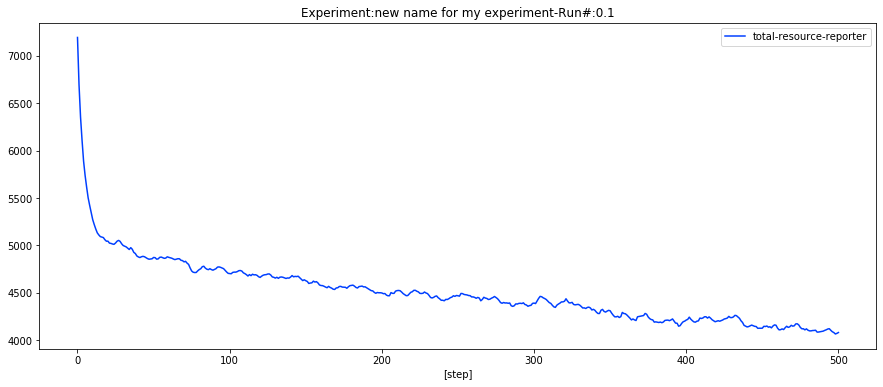

...Graph of total-patch-regrowth vs ticks


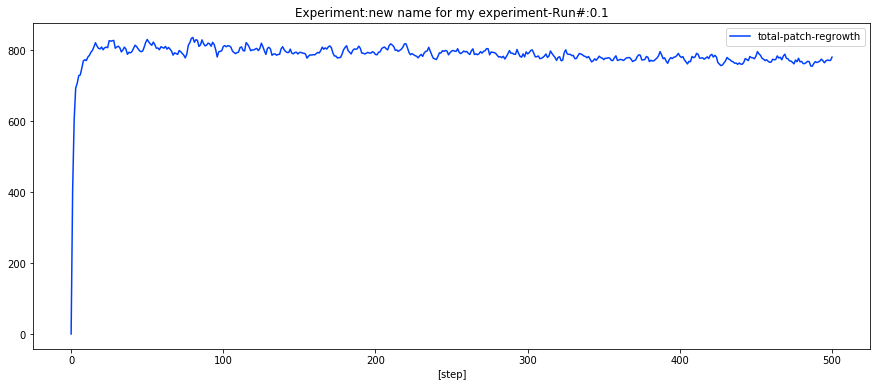

...Graph of total-turtle-resource-reporter vs ticks


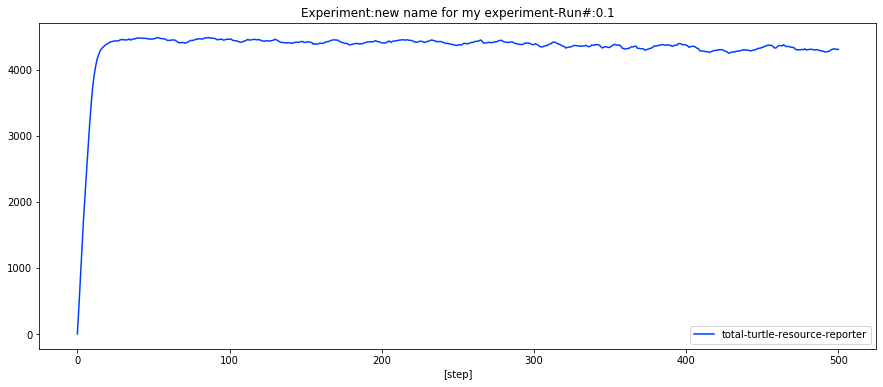

...Graph of total-quantity-harvested vs ticks


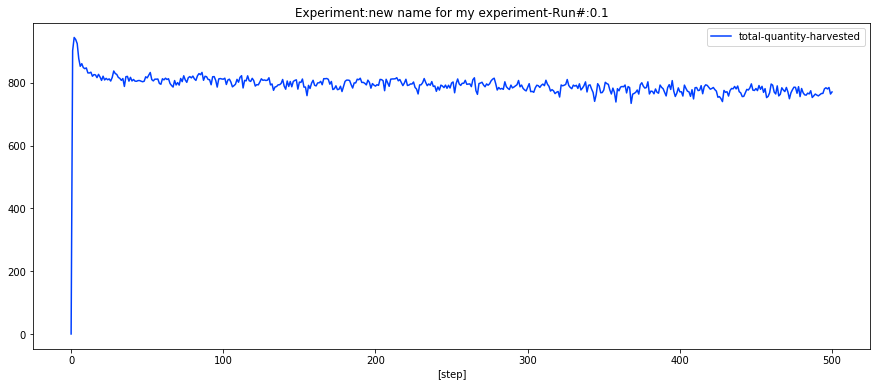

...Graph of number-of-hungry-turtles vs ticks


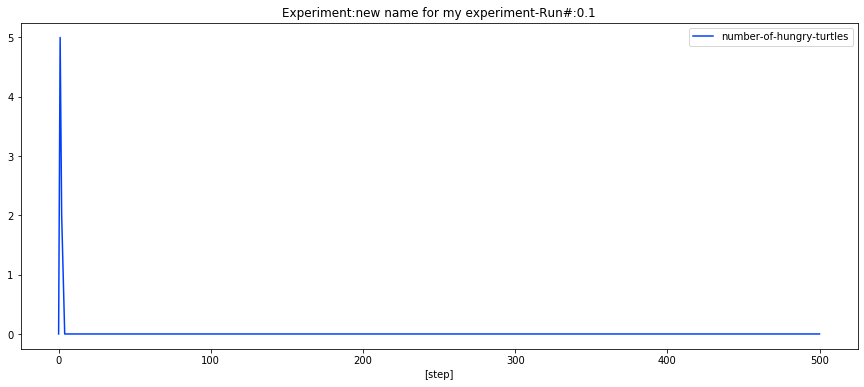

...Graph of total-wealth vs ticks


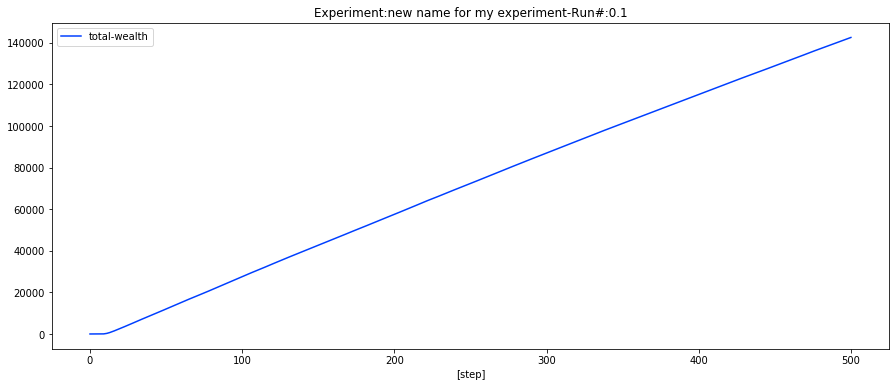

...Graph of total-food-exchanged vs ticks


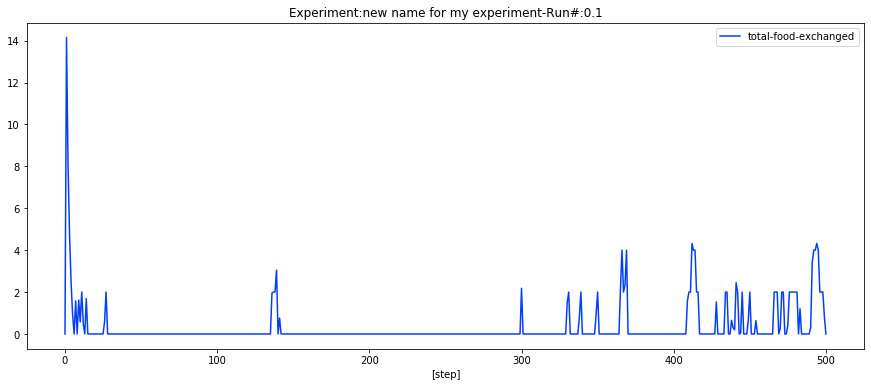

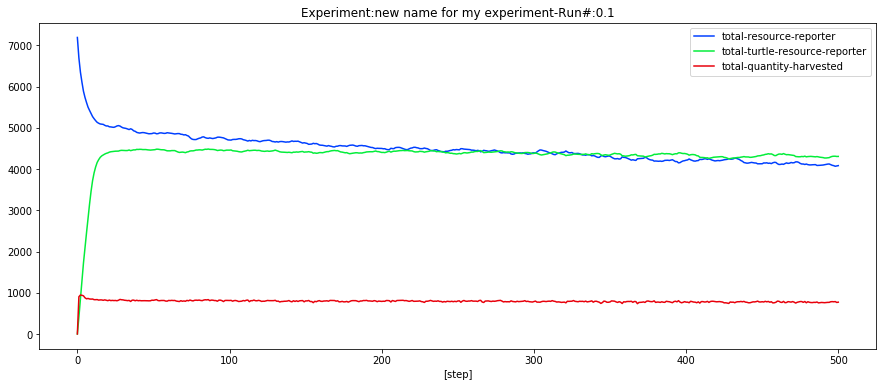

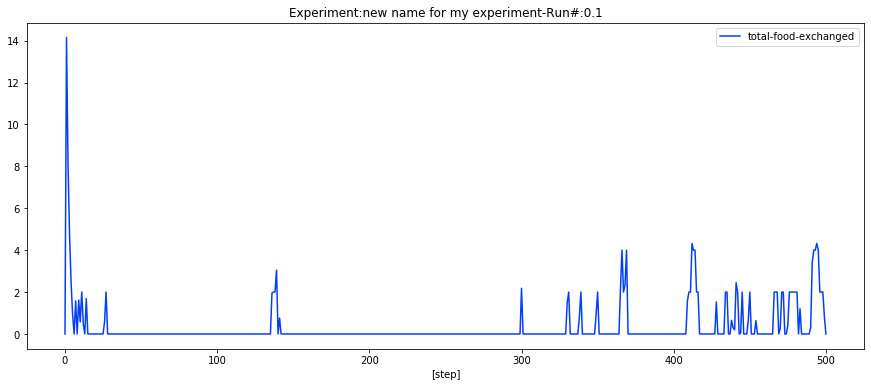

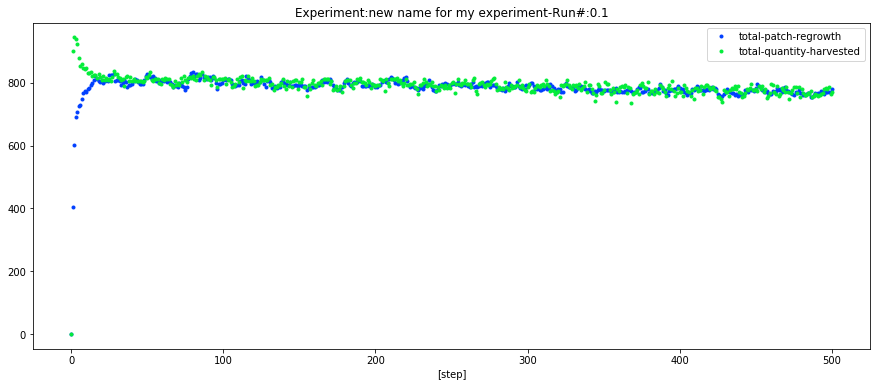

...Graph of total-resource-reporter vs ticks


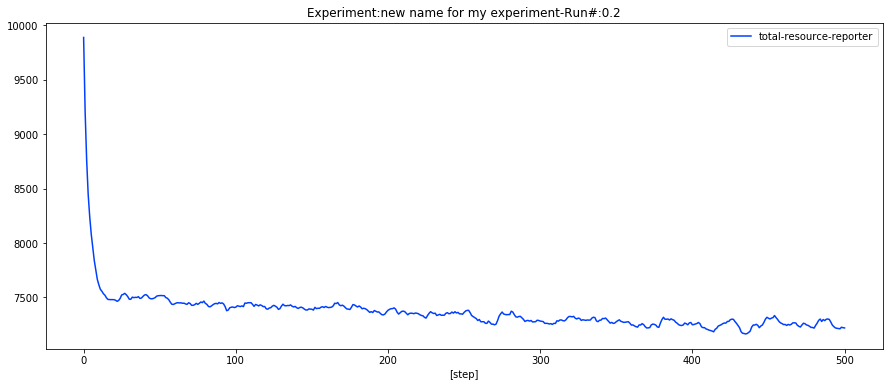

...Graph of total-patch-regrowth vs ticks


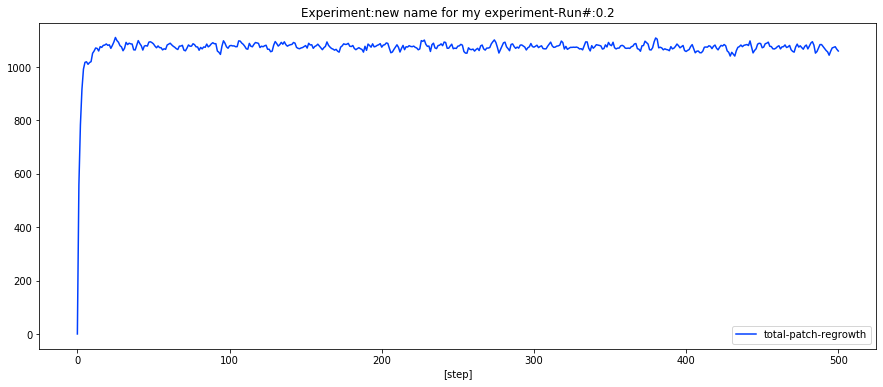

...Graph of total-turtle-resource-reporter vs ticks


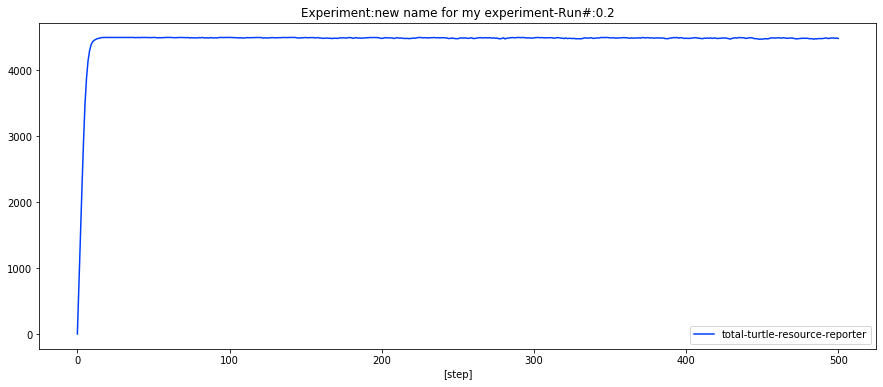

...Graph of total-quantity-harvested vs ticks


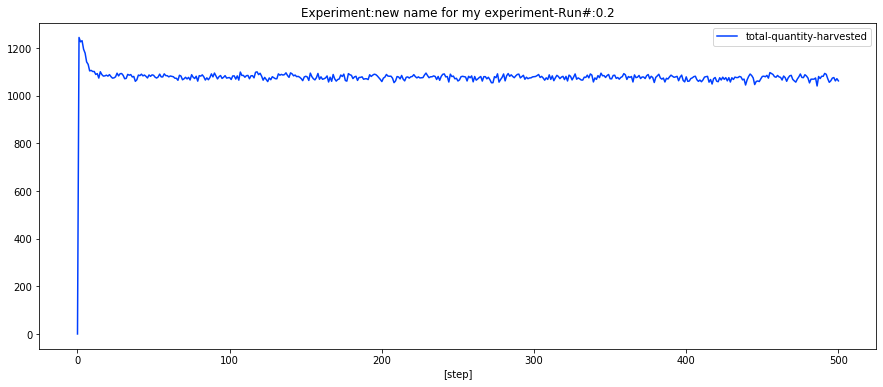

...Graph of number-of-hungry-turtles vs ticks


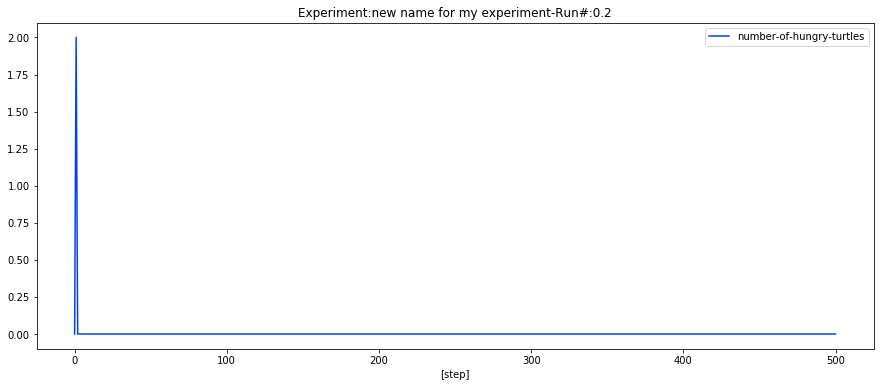

...Graph of total-wealth vs ticks


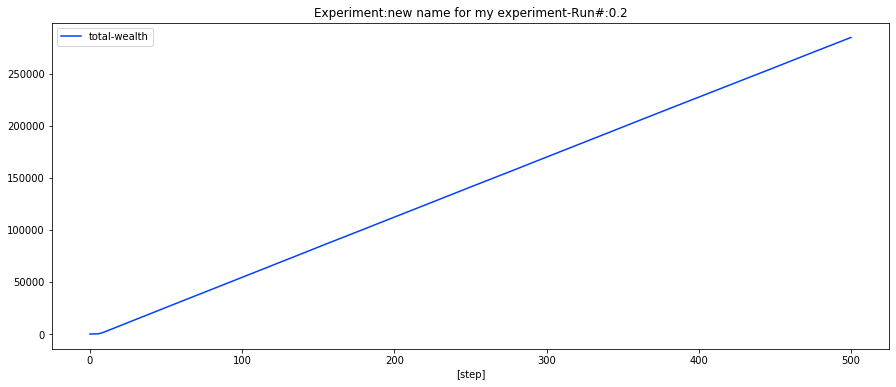

...Graph of total-food-exchanged vs ticks


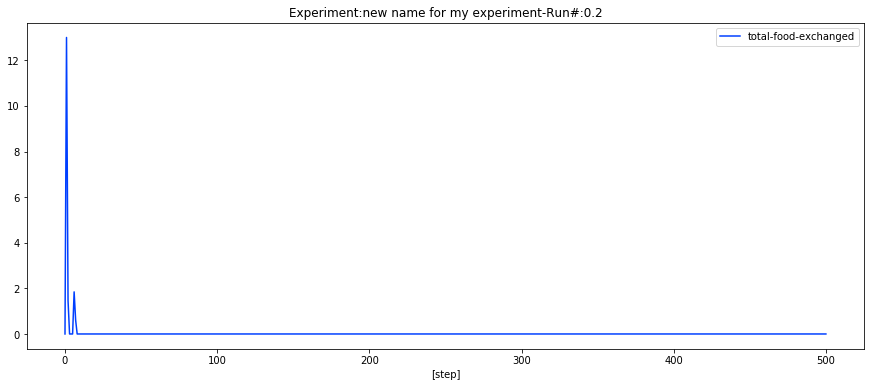

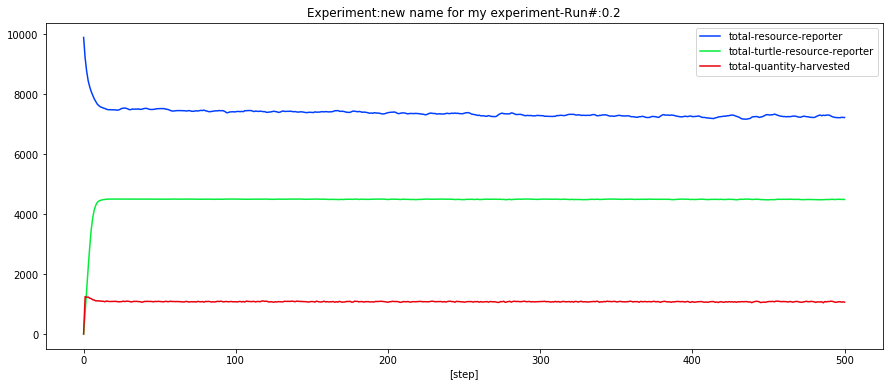

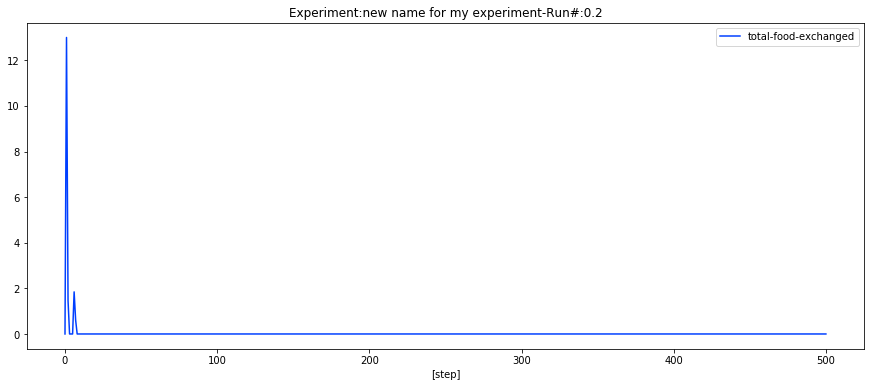

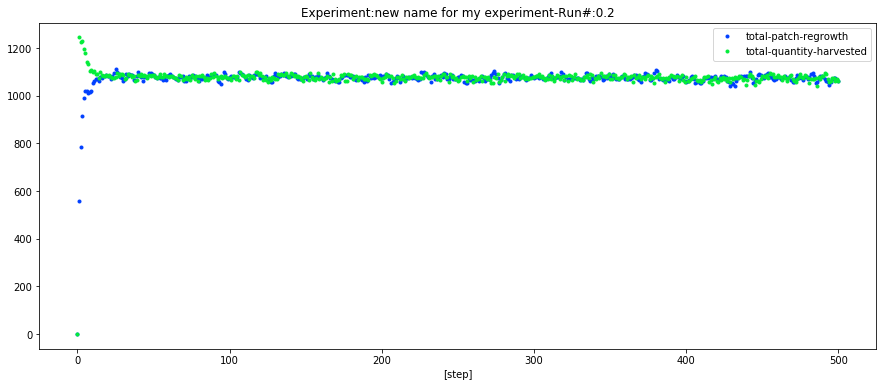

...Graph of total-resource-reporter vs ticks


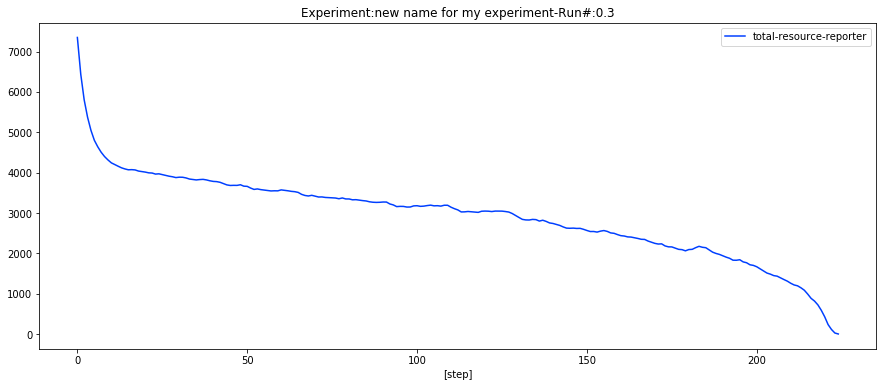

...Graph of total-patch-regrowth vs ticks


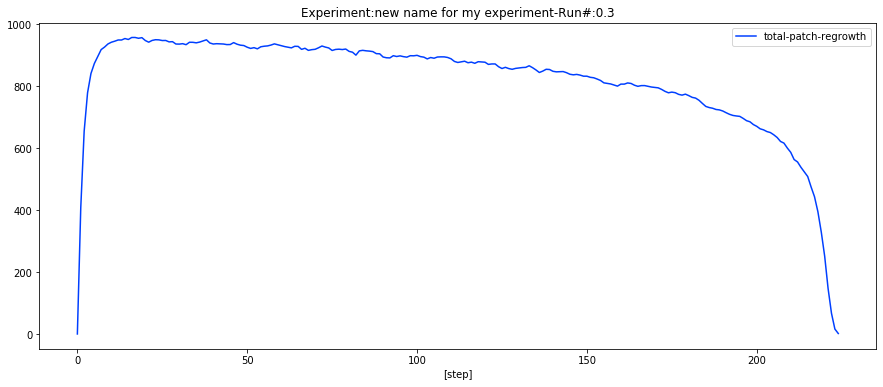

...Graph of total-turtle-resource-reporter vs ticks


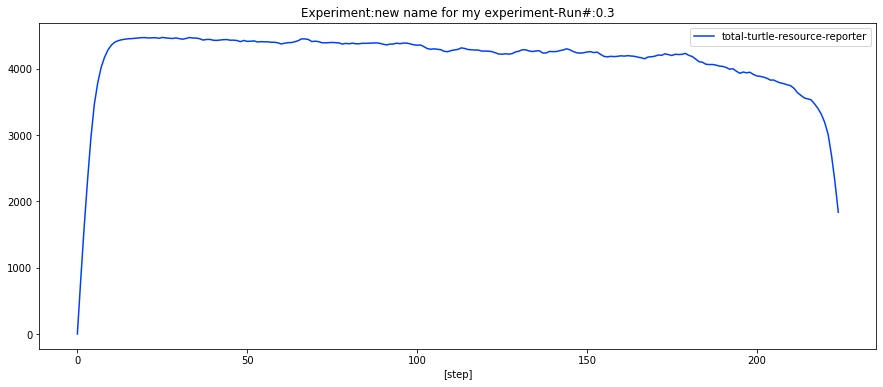

...Graph of total-quantity-harvested vs ticks


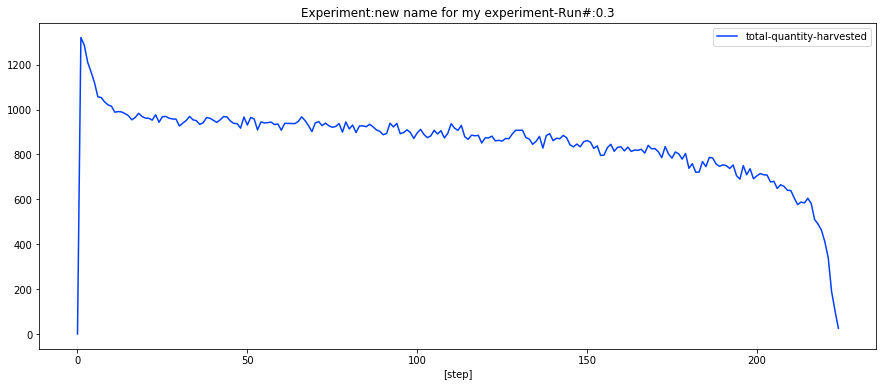

...Graph of number-of-hungry-turtles vs ticks


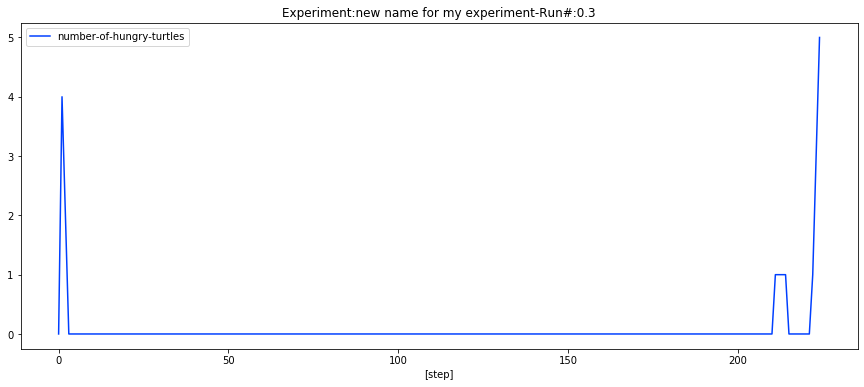

...Graph of total-wealth vs ticks


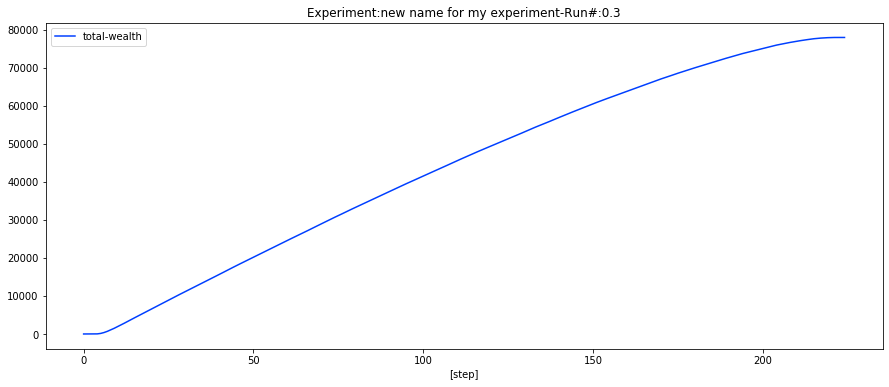

...Graph of total-food-exchanged vs ticks


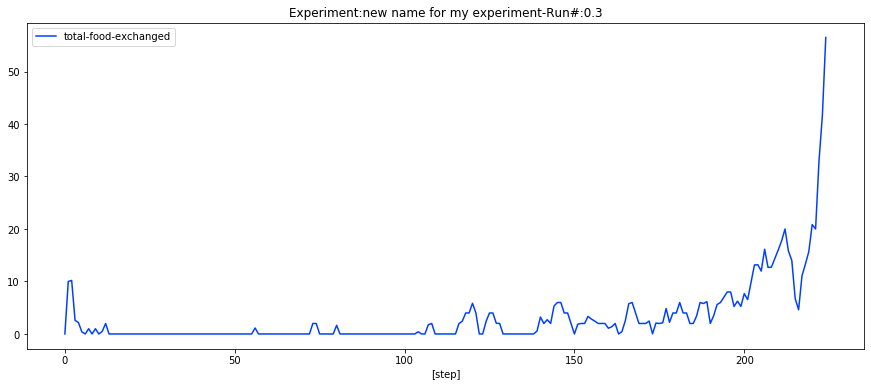

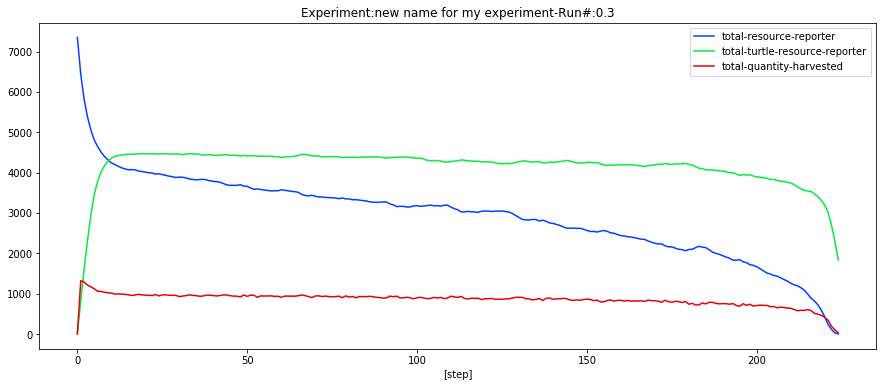

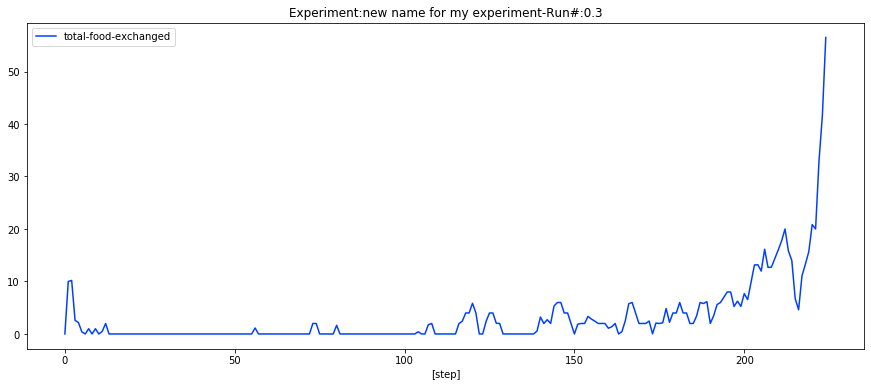

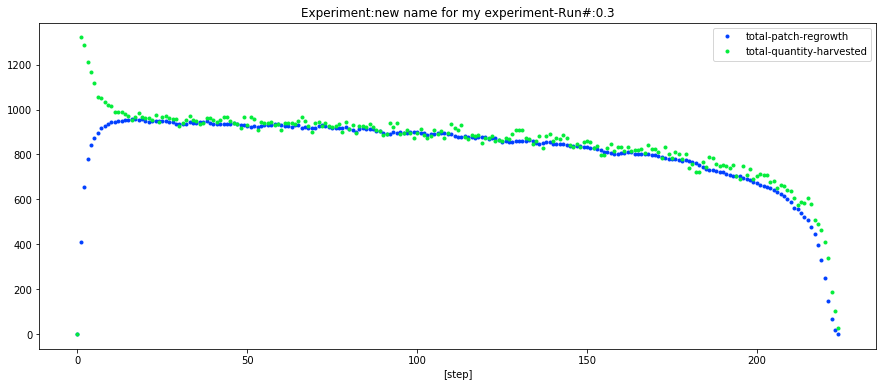

...Graph of total-resource-reporter vs ticks


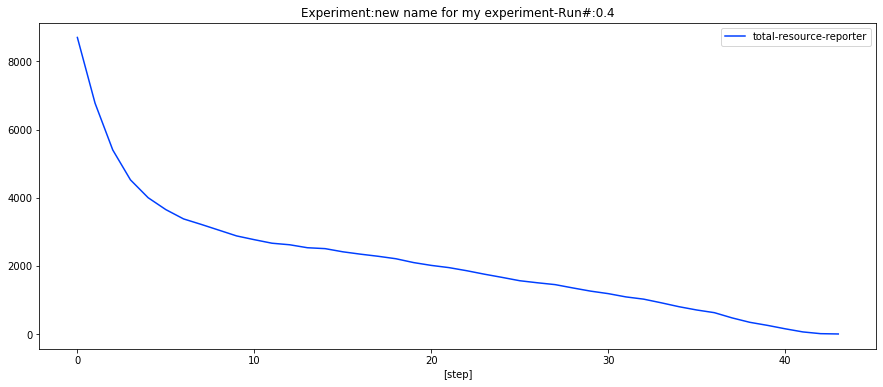

...Graph of total-patch-regrowth vs ticks


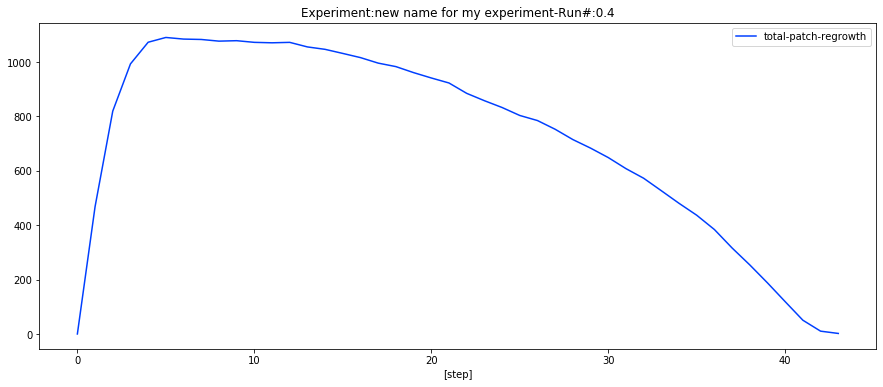

...Graph of total-turtle-resource-reporter vs ticks


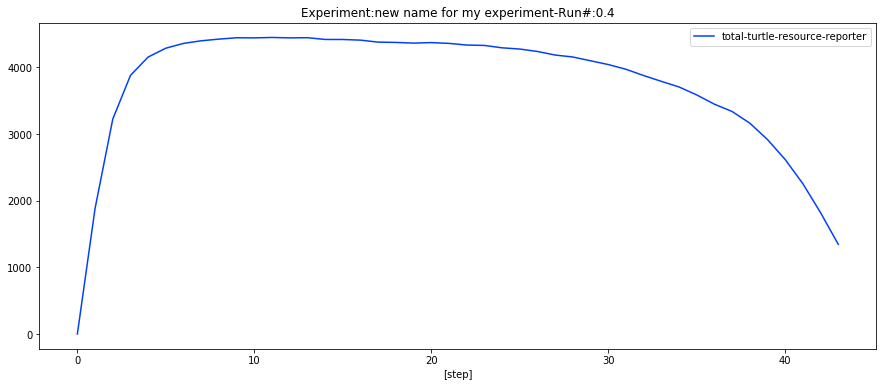

...Graph of total-quantity-harvested vs ticks


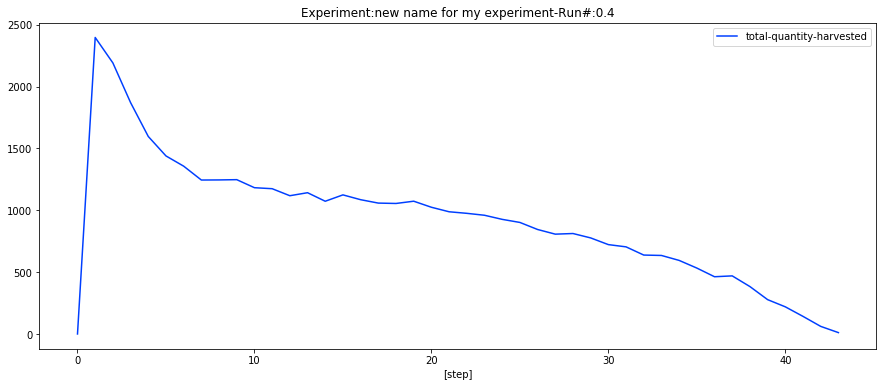

...Graph of number-of-hungry-turtles vs ticks


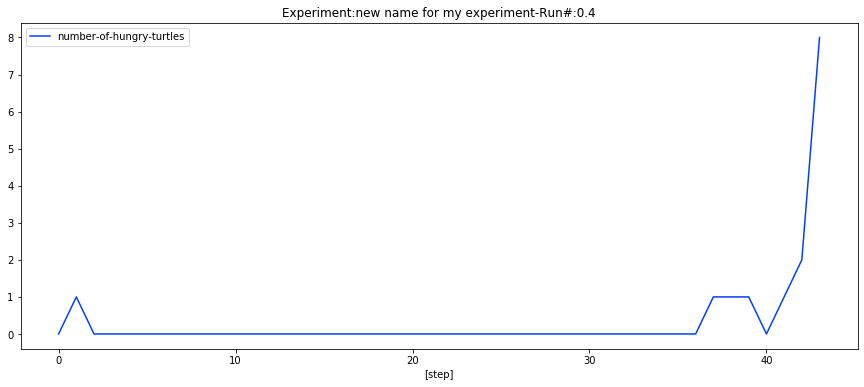

...Graph of total-wealth vs ticks


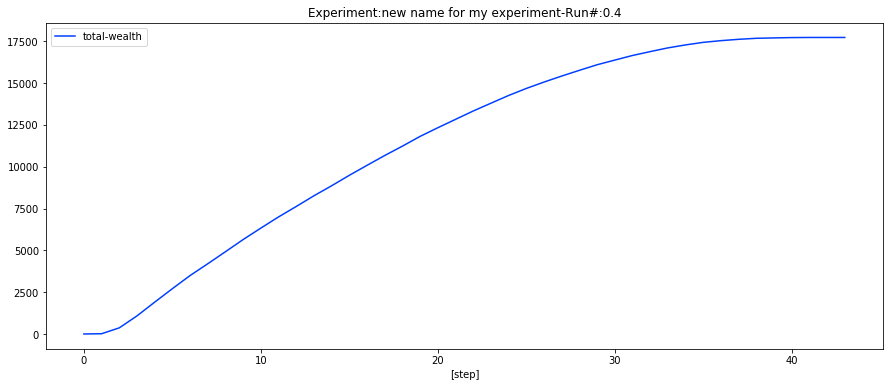

...Graph of total-food-exchanged vs ticks


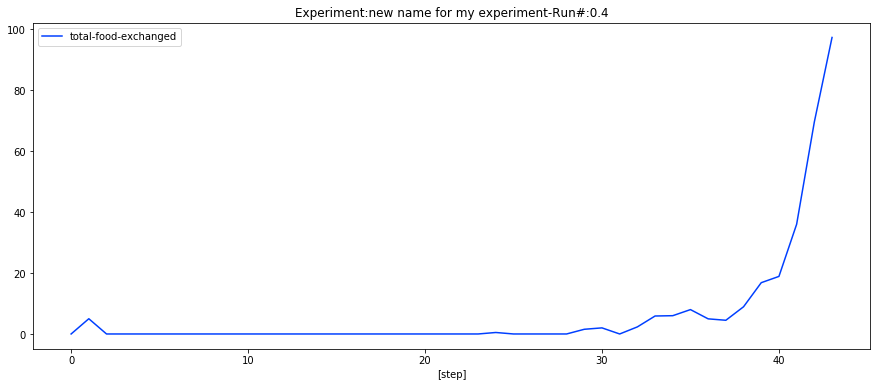

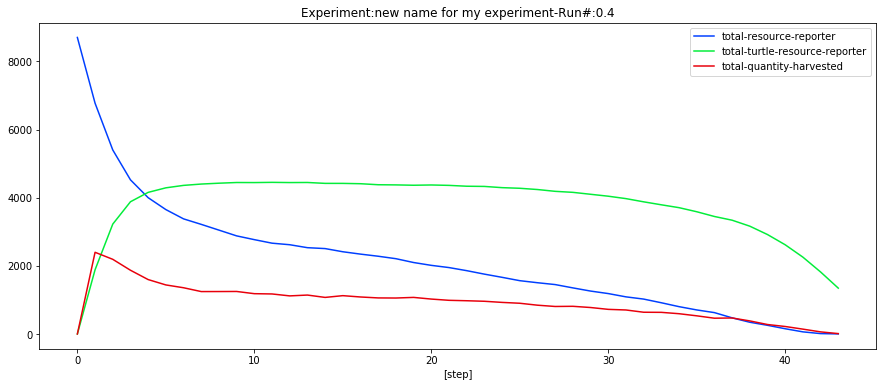

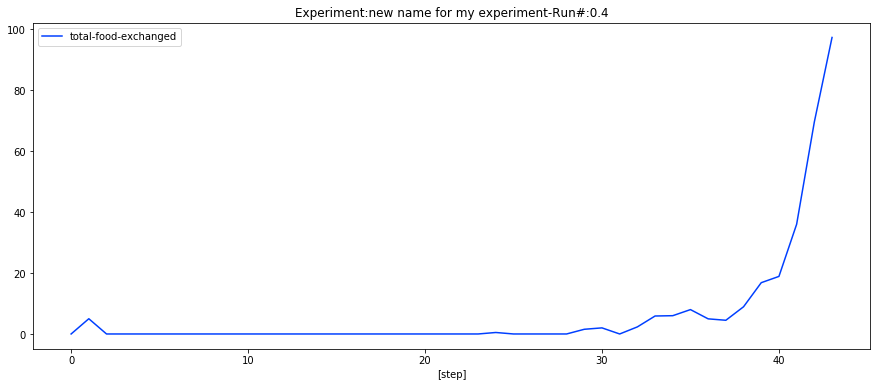

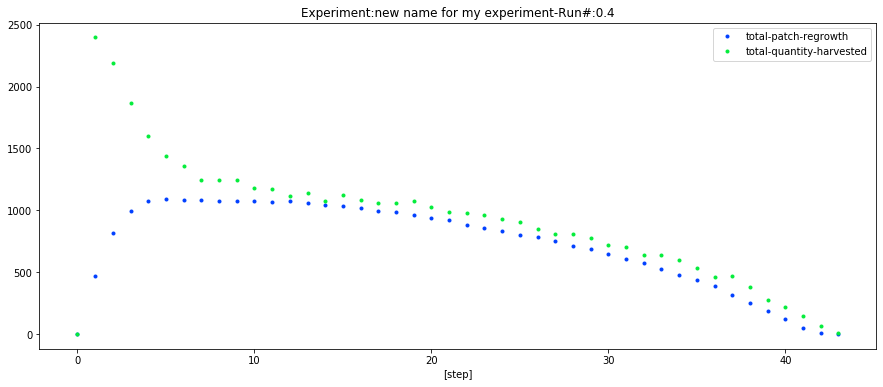

...Graph of total-resource-reporter vs ticks


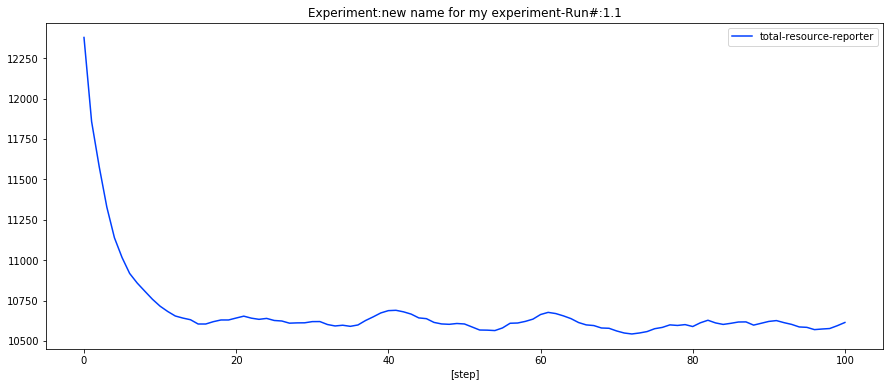

...Graph of total-patch-regrowth vs ticks


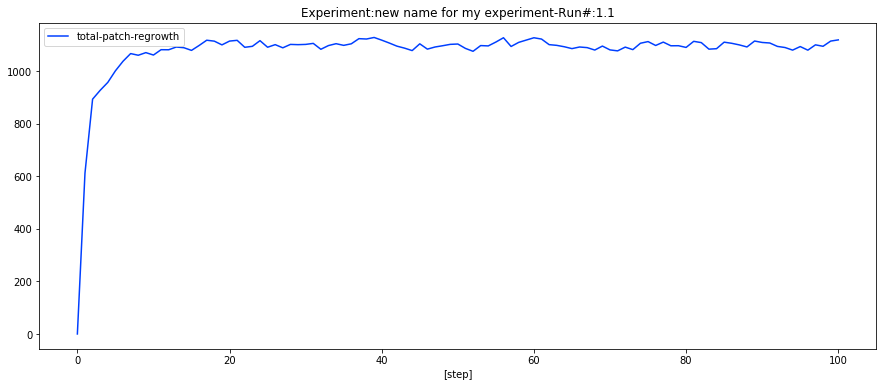

...Graph of total-turtle-resource-reporter vs ticks


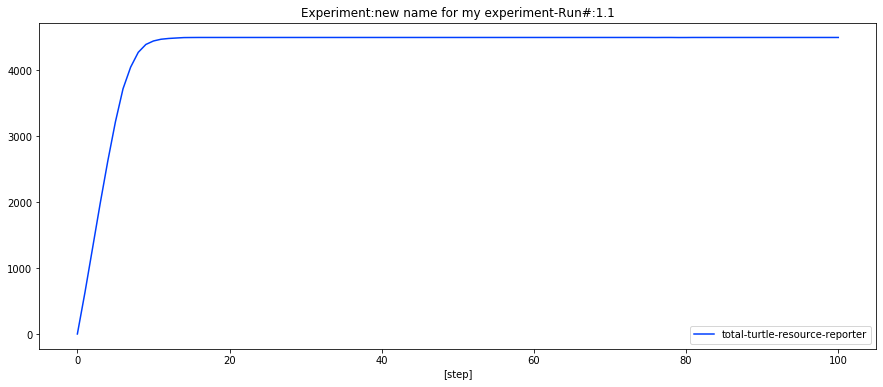

...Graph of total-quantity-harvested vs ticks


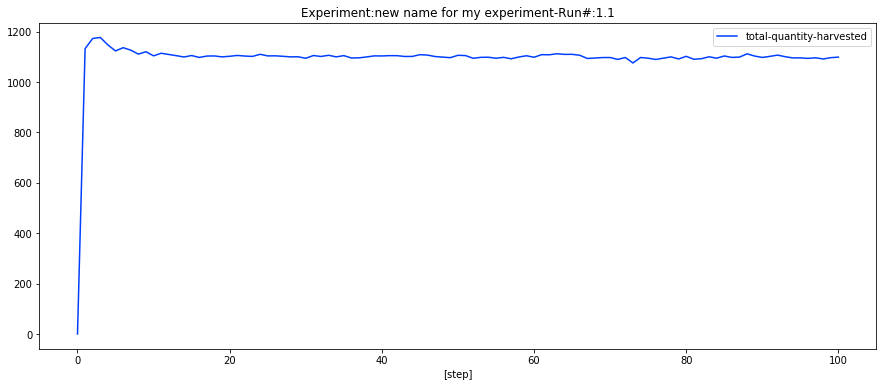

...Graph of number-of-hungry-turtles vs ticks


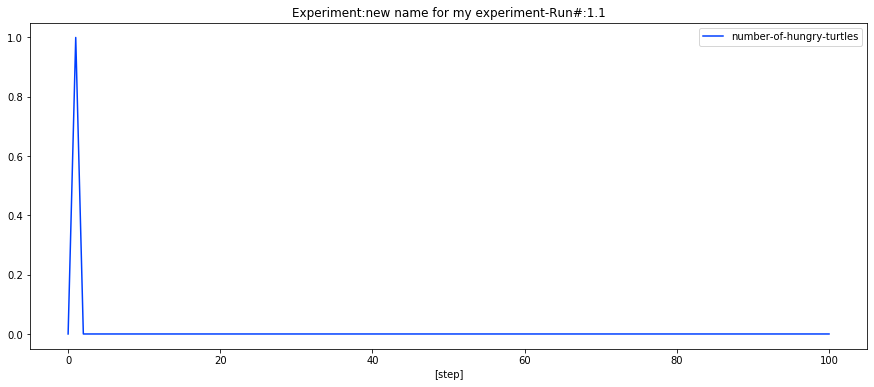

...Graph of total-wealth vs ticks


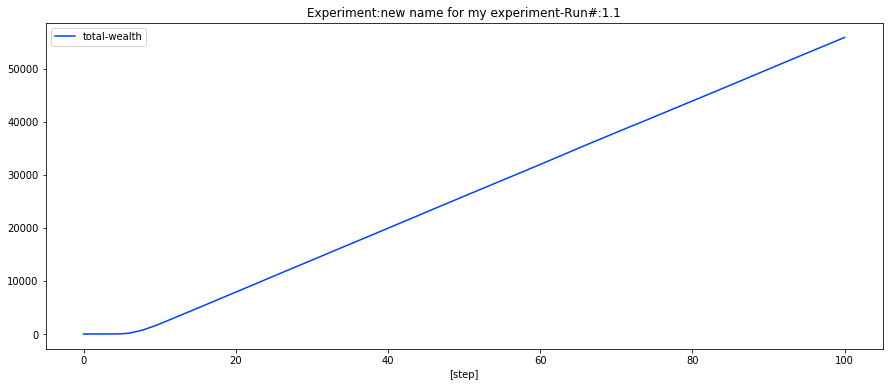

...Graph of total-food-exchanged vs ticks


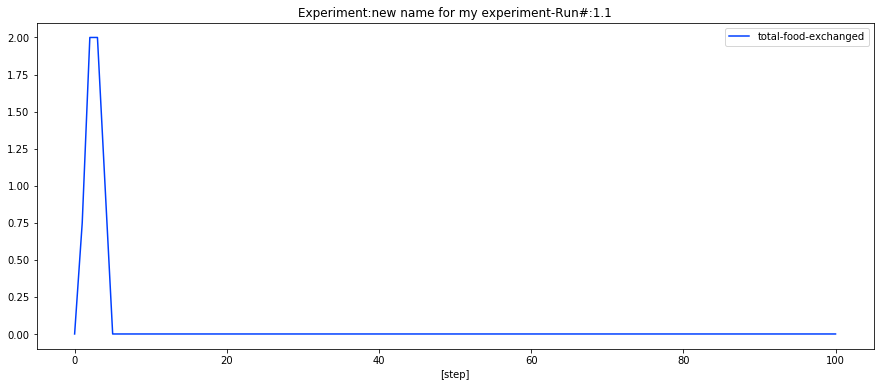

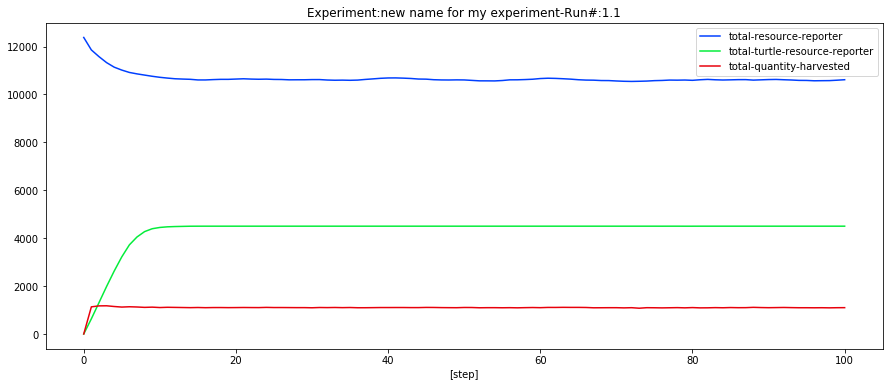

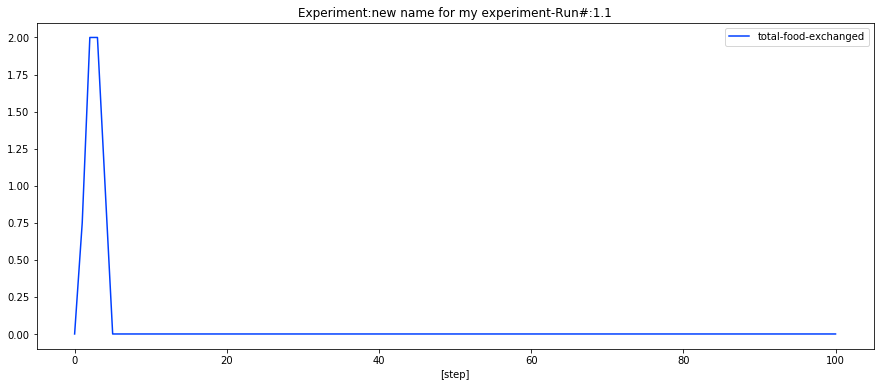

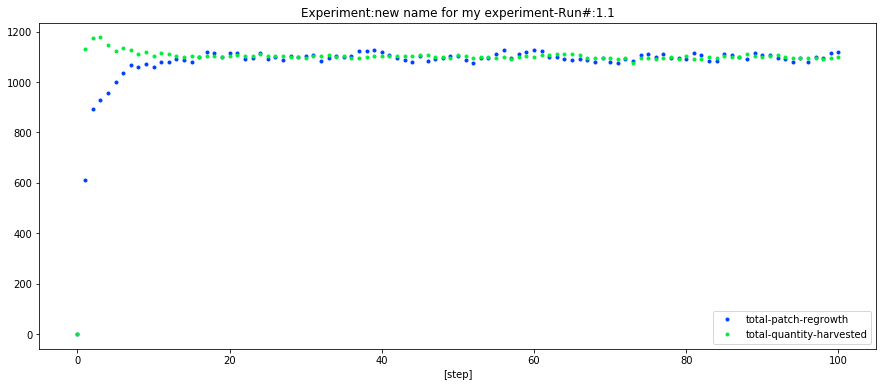

In [64]:
################ MAIN 2.2 ##############################3########
#
#   GENERATING ALL THE STANDARD PLOTS
#   1 PLOT PER EXPERIMENT
#   , ALL RUNS ON THE SAME PLOT
#
#########################################################
process_netlogo_experiments_plots_per_experiment(df)


/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

 Column names for this run :  ['total-resource-reporter-Run#0.1', 'total-turtle-resource-reporter-Run#0.1', 'total-quantity-harvested-Run#0.1']
Generating graph for run number :  0.1
 Column names for this run :  ['total-resource-reporter-Run#0.2', 'total-turtle-resource-reporter-Run#0.2', 'total-quantity-harvested-Run#0.2']
Generating graph for run number :  0.2
 Column names for this run :  ['total-resource-reporter-Run#0.3', 'total-turtle-resource-reporter-Run#0.3', 'total-quantity-harvested-Run#0.3']
Generating graph for run number :  0.3
 Column names for this run :  ['total-resource-reporter-Run#0.4', 'total-turtle-resource-reporter-Run#0.4', 'total-quantity-harvested-Run#0.4']
Generating graph for run number :  0.4
 Column names for this run :  ['total-resource-reporter-Run#1.1', 'total-turtle-resource-reporter-Run#1.1', 'total-quantity-harvested-Run#1.1']
Generating graph for run number :  1.1


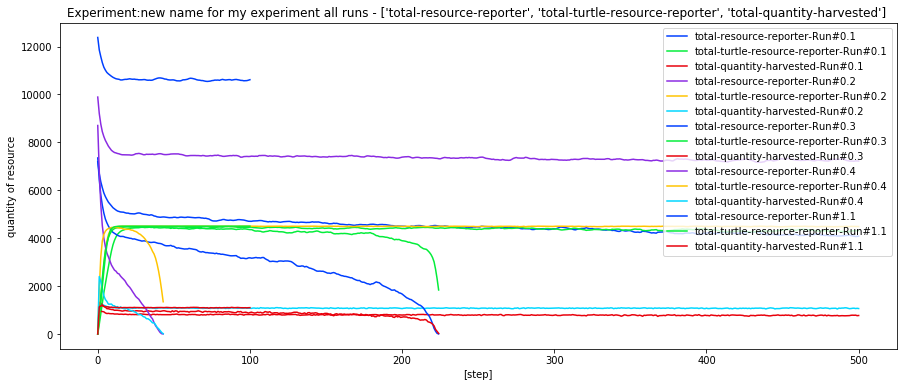

/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Generating ['total-food-exchanged'] graph for run number 0.1: 
Generating ['total-food-exchanged'] graph for run number 0.2: 
Generating ['total-food-exchanged'] graph for run number 0.3: 
Generating ['total-food-exchanged'] graph for run number 0.4: 
Generating ['total-food-exchanged'] graph for run number 1.1: 


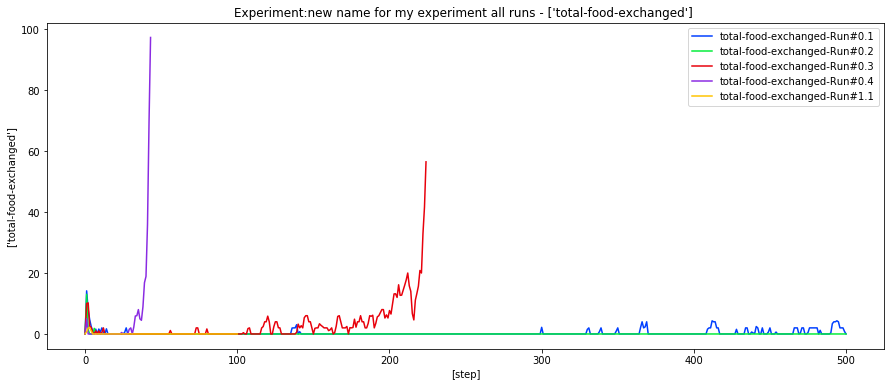

/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Generating ['total-patch-regrowth', 'total-quantity-harvested'] graph for run number 0.1: 
Generating ['total-patch-regrowth', 'total-quantity-harvested'] graph for run number 0.2: 
Generating ['total-patch-regrowth', 'total-quantity-harvested'] graph for run number 0.3: 
Generating ['total-patch-regrowth', 'total-quantity-harvested'] graph for run number 0.4: 
Generating ['total-patch-regrowth', 'total-quantity-harvested'] graph for run number 1.1: 


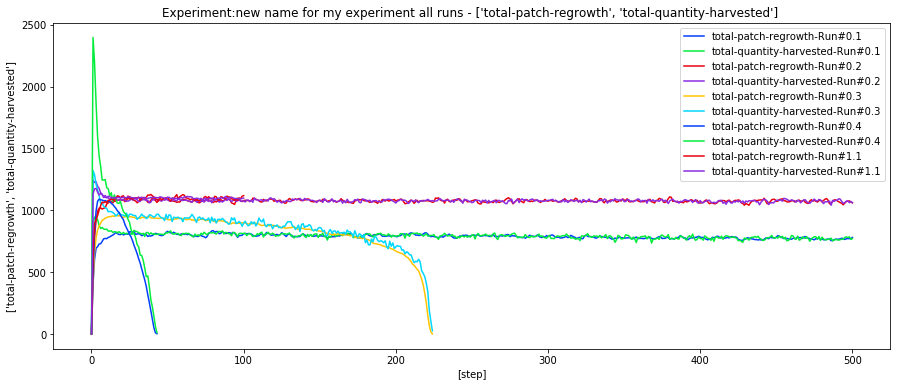

In [63]:
################ MAIN 3 ##############################3########
#
#   G E N E R A T E   ALL REPORTS FOR A SPECIFIC EXPERIMENT
# PUT ALL THE RUNS ON THE SAME GRAPH
#
#########################################################
# don't worry about  these warning :A value is trying to be set on a copy of a slice from a DataFrame

# input
#----------
#experiment_name = 'experiment demo'
experiment_name = 'new name for my experiment'

generate_all_reports_per_experiment(df, experiment_name)



/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/isischameleon/Dropbox/miniconda3/envs/networkx/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Generating ['total-resource-reporter', 'total-patch-regrowth'] graph for run number 1: 
Generating ['total-resource-reporter', 'total-patch-regrowth'] graph for run number 2: 
Generating ['total-resource-reporter', 'total-patch-regrowth'] graph for run number 3: 
Generating ['total-resource-reporter', 'total-patch-regrowth'] graph for run number 4: 


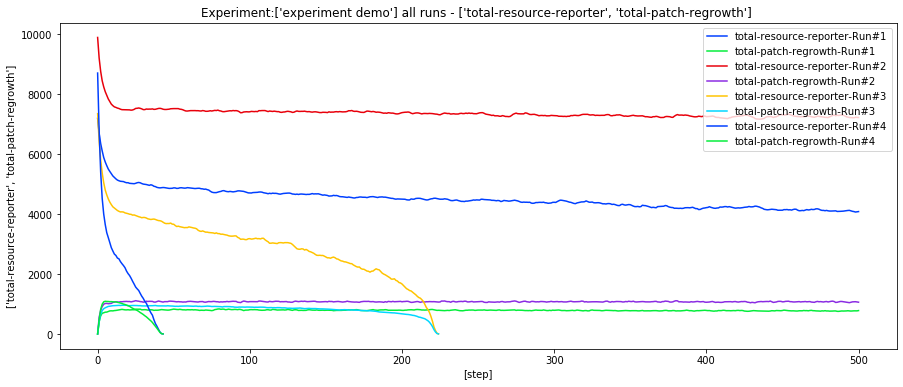

In [43]:
################ MAIN 4 ##############################3########
#
#   G E N E R A T E   A REPORT FOR A SPECIFIC EXPERIMENT
# PUT ALL THE RUNS ON THE SAME GRAPH
#  >>>> YOU CHOOSE THE COLUMNS TO BE PRINTED ON THE PLOT
#  >>>> YOU CHOOSE THE EXPERIMENT NAME 
#  >>>> it will work provided it's amongst the csv files that you have loaded in df
#
#########################################################
# don't worry about  these warning :A value is trying to be set on a copy of a slice from a DataFrame

#INPUT:
#------
 
col_names = ['total-resource-reporter', 'total-patch-regrowth']
experiment_name = ['experiment demo']

generate_columns_vs_ticks_report_per_experiment(df, experiment_name, col_names)

""


In [ ]:
#################################